**Please note this contains the first 70 subjects in the prediction dataset the insights are not complete yet**

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
!git clone https://github.com/ashmitg/cxr-image-analysis

fatal: destination path 'cxr-image-analysis' already exists and is not an empty directory.


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Test_set_prediction_with_relative_image_paths_first_70_unique.csv')


In [ ]:
df.size

6171

In [ ]:
df.head()

,subject_id,age,race,gender,pred_0,label_0,pred_1,label_1,pred_2,label_2,pred_3,label_3,pred_4,label_4,pred_5,label_5,image_path
0,11812752,68,WHITE,F,0.056143,0,0.015012,0,0.001175,0,0.004269,0,0.091285,0,0.759478,1,cxr-image-analysis/files/p11/p11812752/s582931...
1,11812752,68,WHITE,F,0.051060,0,0.006028,0,0.001799,0,0.006515,0,0.050387,0,0.863849,1,cxr-image-analysis/files/p11/p11812752/s582931...
2,11812752,68,WHITE,F,0.021372,0,0.004059,0,0.000743,0,0.004475,0,0.092967,0,0.849508,1,cxr-image-analysis/files/p11/p11812752/s584125...
3,11812752,68,WHITE,F,0.031842,0,0.001862,0,0.000797,0,0.006196,0,0.047191,0,0.934808,1,cxr-image-analysis/files/p11/p11812752/s584125...
4,15197921,-1,NaN,NaN,0.034598,0,0.010697,0,0.000503,0,0.005243,0,0.077575,0,0.871780,1,cxr-image-analysis/files/p15/p15197921/s595509...


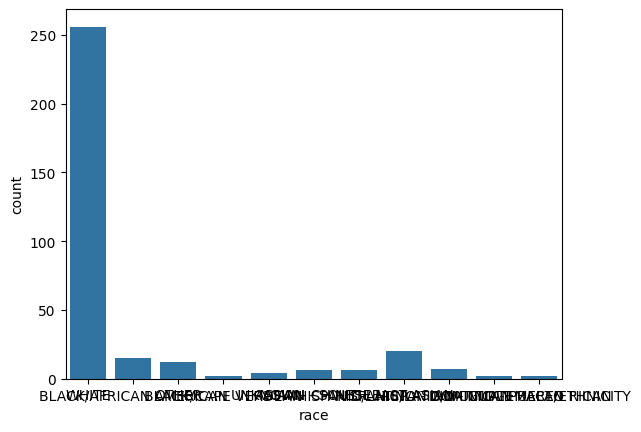

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='race', data=df)
plt.show()


In [ ]:
df.head()

,subject_id,age,race,gender,pred_0,label_0,pred_1,label_1,pred_2,label_2,pred_3,label_3,pred_4,label_4,pred_5,label_5,image_path
0,11812752,68,WHITE,F,0.056143,0,0.015012,0,0.001175,0,0.004269,0,0.091285,0,0.759478,1,cxr-image-analysis/files/p11/p11812752/s582931...
1,11812752,68,WHITE,F,0.051060,0,0.006028,0,0.001799,0,0.006515,0,0.050387,0,0.863849,1,cxr-image-analysis/files/p11/p11812752/s582931...
2,11812752,68,WHITE,F,0.021372,0,0.004059,0,0.000743,0,0.004475,0,0.092967,0,0.849508,1,cxr-image-analysis/files/p11/p11812752/s584125...
3,11812752,68,WHITE,F,0.031842,0,0.001862,0,0.000797,0,0.006196,0,0.047191,0,0.934808,1,cxr-image-analysis/files/p11/p11812752/s584125...
4,15197921,-1,NaN,NaN,0.034598,0,0.010697,0,0.000503,0,0.005243,0,0.077575,0,0.871780,1,cxr-image-analysis/files/p15/p15197921/s595509...


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
import numpy as np

def load_and_preprocess_image(image_path):
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return img_array

image_paths = df['image_path'].values
images = np.vstack([load_and_preprocess_image(path) for path in image_paths])


In [ ]:
model = tf.keras.applications.VGG16(weights='imagenet', include_top=False, pooling='avg')
predictions = model.predict(images)


12/12 ━━━━━━━━━━━━━━━━━━━━ 22s 668ms/step


In [ ]:
df['max_pred'] = df[['pred_0', 'pred_1', 'pred_2', 'pred_3', 'pred_4', 'pred_5']].max(axis=1)
threshold = df['max_pred'].quantile(0.75)

high_scoring_df = df[df['max_pred'] >= threshold]
low_scoring_df = df[df['max_pred'] < threshold]

In [ ]:
threshold

0.7922807249999999

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step


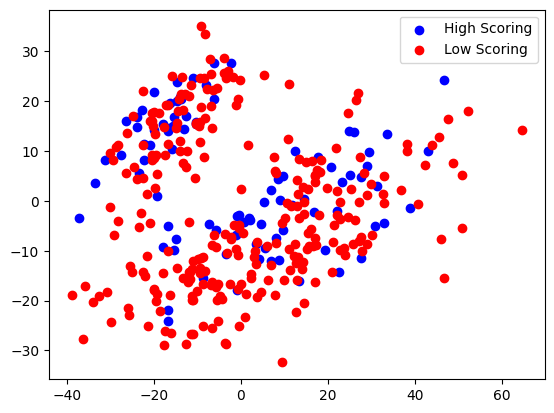

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

features = model.predict(images)

pca = PCA(n_components=2)
reduced_features = pca.fit_transform(features)

plt.scatter(reduced_features[high_scoring_df.index, 0], reduced_features[high_scoring_df.index, 1], c='blue', label='High Scoring')
plt.scatter(reduced_features[low_scoring_df.index, 0], reduced_features[low_scoring_df.index, 1], c='red', label='Low Scoring')
plt.legend()
plt.show()


<ipython-input-16-6bc7ac7cc652>:35: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = plt.cm.get_cmap("jet")


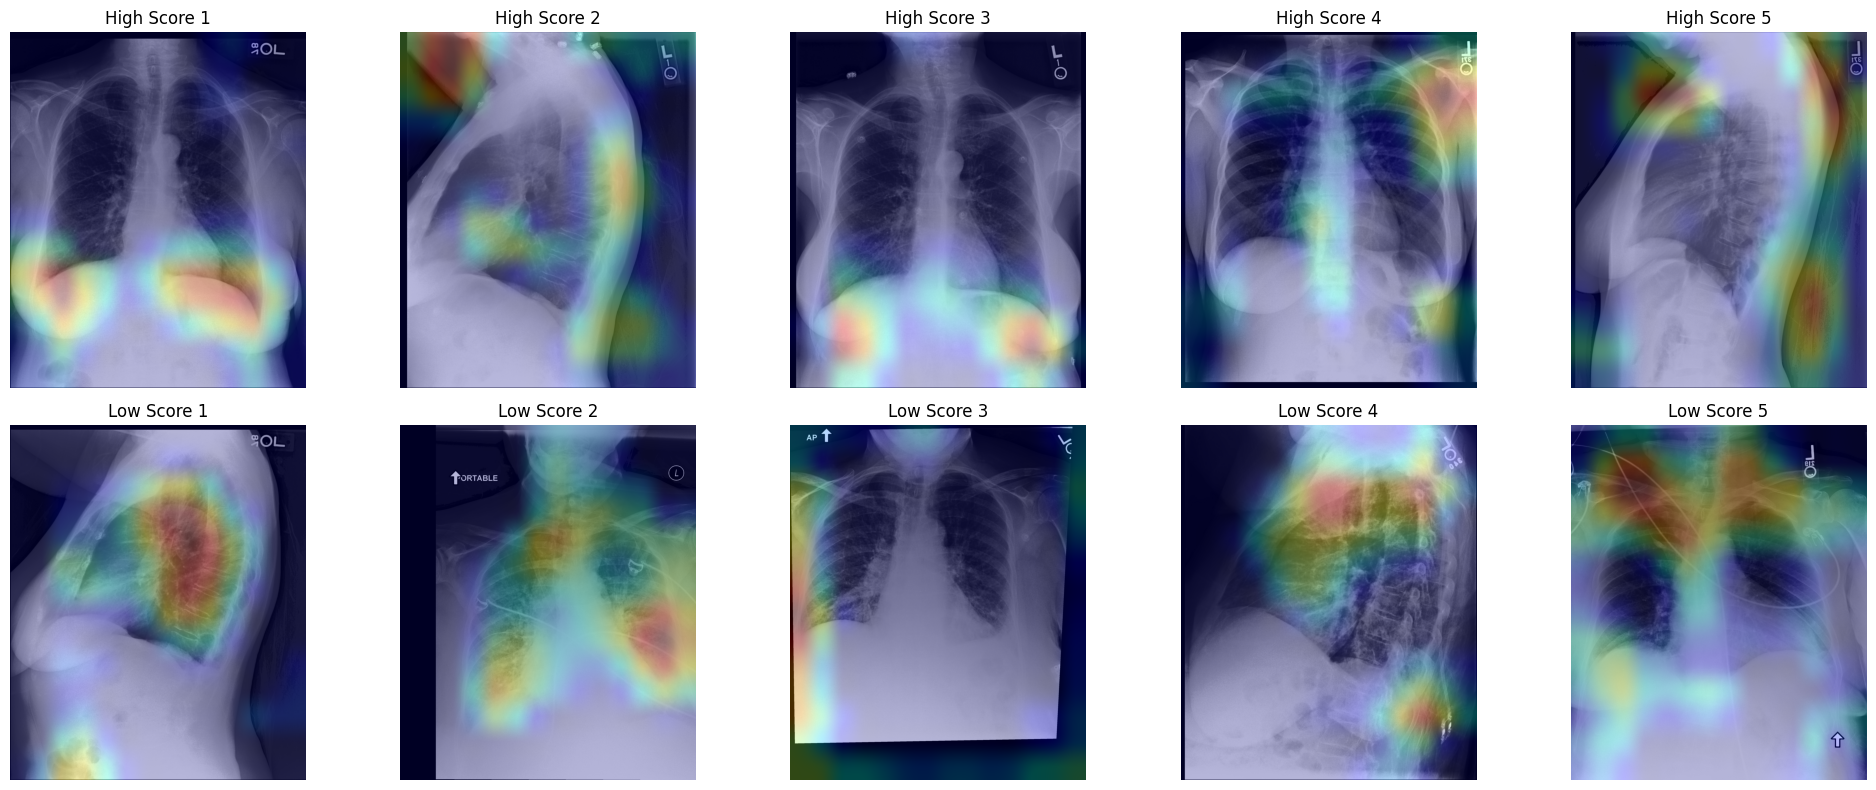

In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def get_img_array(img_path, size):
    img = load_img(img_path, target_size=size)
    array = img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def plot_heatmap(img_path, heatmap, alpha=0.4):
    img = load_img(img_path)
    img = img_to_array(img)

    heatmap = np.uint8(255 * heatmap)
    jet = plt.cm.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

    return superimposed_img
#one of the final layers of imagenet
last_conv_layer_name = "block5_conv3"

def process_image(img_path, model):
    img_array = get_img_array(img_path, (224, 224)) 
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
    superimposed_img = plot_heatmap(img_path, heatmap)
    return superimposed_img

high_heatmaps = [process_image(path, model) for path in high_scoring_df['image_path']]

low_heatmaps = [process_image(path, model) for path in low_scoring_df['image_path']]

# Plot heatmaps
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
for i, img in enumerate(high_heatmaps[:5]):
    axes[0, i].imshow(img)
    axes[0, i].set_title(f"High Score {i+1}")
    axes[0, i].axis('off')

for i, img in enumerate(low_heatmaps[:5]):
    axes[1, i].imshow(img)
    axes[1, i].set_title(f"Low Score {i+1}")
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()


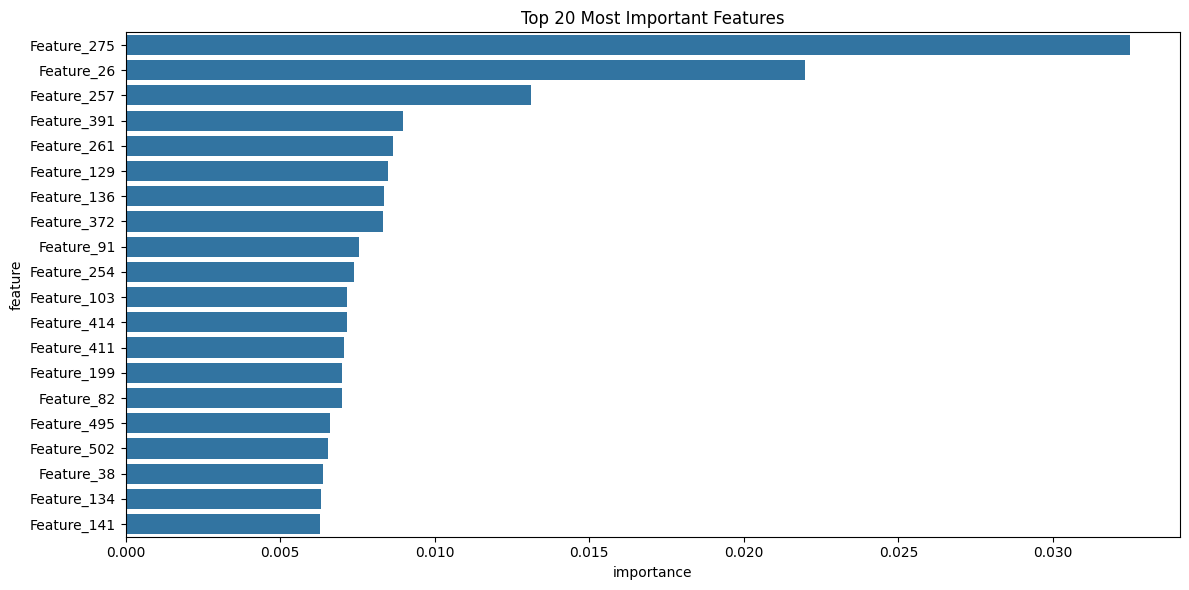

T-Test Results:
brightness:
  t-statistic: 0.2513
  p-value: 0.8017

contrast:
  t-statistic: -0.5052
  p-value: 0.6137

texture:
  t-statistic: -2.0719
  p-value: 0.0390



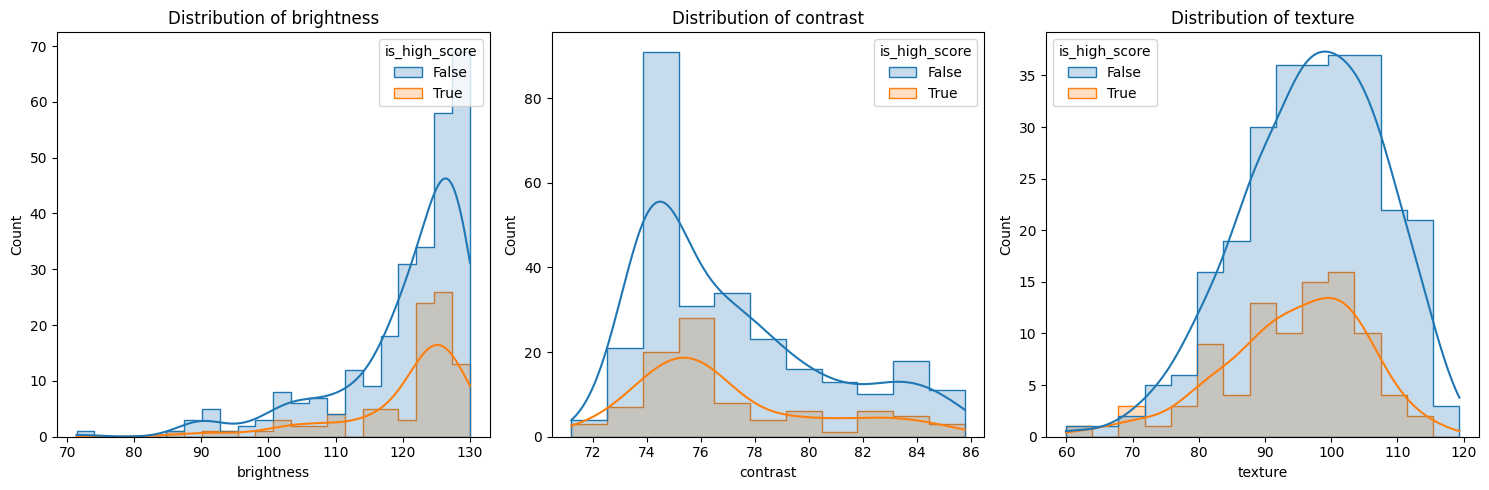

In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

labels = (df['max_pred'] >= threshold).astype(int)

rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(features, labels)

importances = rf_classifier.feature_importances_
feature_names = [f"Feature_{i}" for i in range(len(importances))]

feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
feature_importance_df = feature_importance_df.sort_values('importance', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x='importance', y='feature', data=feature_importance_df.head(20))
plt.title('Top 20 Most Important Features')
plt.tight_layout()
plt.show()


def extract_image_characteristics(image_path):
    img = plt.imread(image_path)
    return {
        'brightness': np.mean(img),
        'contrast': np.std(img),
        'texture': np.mean(np.abs(np.diff(img)))
    }

image_characteristics = df['image_path'].apply(extract_image_characteristics)
df_characteristics = pd.DataFrame(image_characteristics.tolist(), index=df.index)

df_combined = pd.concat([df, df_characteristics], axis=1)

df_combined['is_high_score'] = df_combined['max_pred'] >= threshold

characteristics = ['brightness', 'contrast', 'texture']
t_test_results = {}

for char in characteristics:
    high_scores = df_combined[df_combined['is_high_score']][char]
    low_scores = df_combined[~df_combined['is_high_score']][char]

    t_stat, p_value = stats.ttest_ind(high_scores, low_scores)
    t_test_results[char] = {'t_statistic': t_stat, 'p_value': p_value}

print("T-Test Results:")
for char, result in t_test_results.items():
    print(f"{char}:")
    print(f"  t-statistic: {result['t_statistic']:.4f}")
    print(f"  p-value: {result['p_value']:.4f}")
    print()

plt.figure(figsize=(15, 5))
for i, char in enumerate(characteristics):
    plt.subplot(1, 3, i+1)
    sns.histplot(data=df_combined, x=char, hue='is_high_score', kde=True, element='step')
    plt.title(f'Distribution of {char}')
plt.tight_layout()
plt.show()

Descriptive Statistics by Race:

Brightness by Race:
                                count        mean        std         min  \
race                                                                       
ASIAN - CHINESE                   6.0  122.373616   6.819514  108.671706   
ASIAN - SOUTH EAST ASIAN          6.0  114.646010  16.342516   87.257630   
BLACK/AFRICAN AMERICAN           15.0  115.807557  15.688142   71.403606   
BLACK/CAPE VERDEAN                2.0  112.064413   0.258917  111.881331   
HISPANIC/LATINO - DOMINICAN      20.0  114.644034  11.977059   86.507705   
HISPANIC/LATINO - GUATEMALAN      7.0  119.637224  13.920962   88.494933   
HISPANIC/LATINO - PUERTO RICAN    2.0   96.165956   4.502300   92.982349   
MULTIPLE RACE/ETHNICITY           2.0  123.719476   6.631335  119.030414   
OTHER                            12.0  117.768290  11.400382   90.657118   
UNKNOWN                           4.0  123.387150   4.411432  117.262042   
WHITE                           256

/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:4102: DegenerateDataWarning: at least one input has length 0
  if _f_oneway_is_too_small(samples):


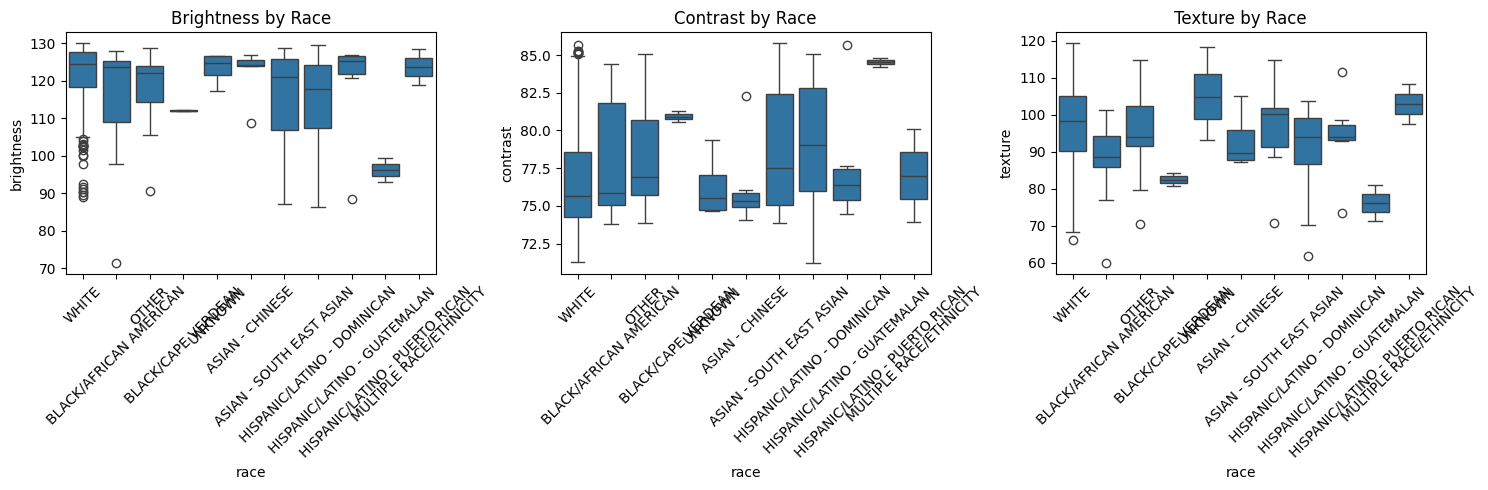


Mutual Information Scores:
With Race:
      feature  mi_score
0  brightness  0.063757
2     texture  0.046445
1    contrast  0.043342

With Score:
      feature  mi_score
1    contrast  0.011410
0  brightness  0.004758
2     texture  0.000000


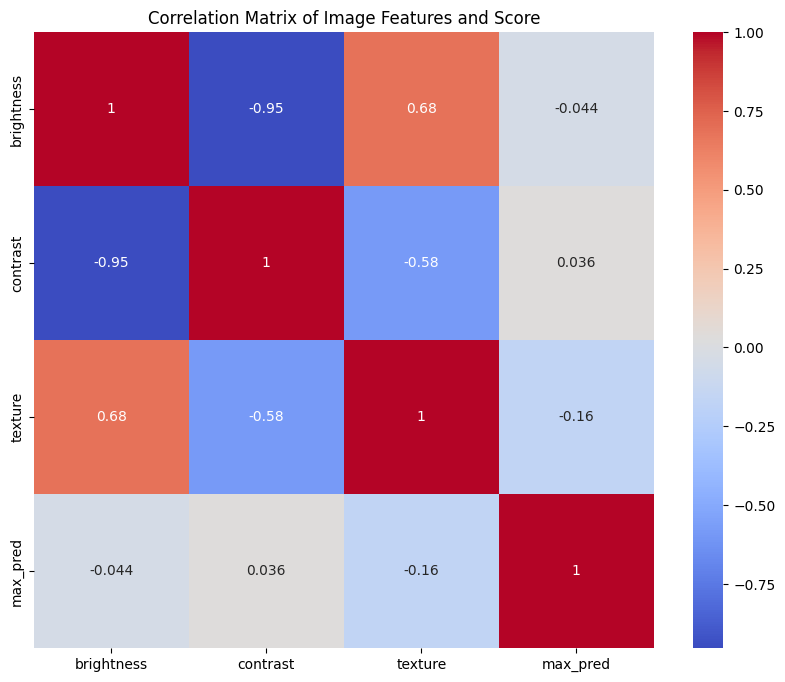

In [ ]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import mutual_info_regression


print("Descriptive Statistics by Race:")
for feature in ['brightness', 'contrast', 'texture']:
    print(f"\n{feature.capitalize()} by Race:")
    print(df_combined.groupby('race')[feature].describe())

def anova_test(df, feature):
    races = df['race'].unique()
    samples = [df[df['race'] == race][feature] for race in races]
    f_value, p_value = stats.f_oneway(*samples)
    return f_value, p_value

print("\nANOVA Test Results:")
for feature in ['brightness', 'contrast', 'texture']:
    f_value, p_value = anova_test(df_combined, feature)
    print(f"{feature.capitalize()}:")
    print(f"  F-statistic: {f_value:.4f}")
    print(f"  p-value: {p_value:.4f}")

plt.figure(figsize=(15, 5))
for i, feature in enumerate(['brightness', 'contrast', 'texture']):
    plt.subplot(1, 3, i+1)
    sns.boxplot(x='race', y=feature, data=df_combined)
    plt.title(f'{feature.capitalize()} by Race')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

def calculate_mi(df, features, target):
    X = df[features]
    y = df[target]
    if y.dtype == 'object': 
        le = LabelEncoder()
        y = le.fit_transform(y)
    if target == 'race':
        mi_scores = mutual_info_classif(X, y)
    else:
        mi_scores = mutual_info_regression(X, y)
    mi_df = pd.DataFrame({'feature': features, 'mi_score': mi_scores})
    return mi_df.sort_values('mi_score', ascending=False)



features = ['brightness', 'contrast', 'texture']
mi_race = calculate_mi(df_combined, features, 'race')
mi_score = calculate_mi(df_combined, features, 'max_pred')

print("\nMutual Information Scores:")
print("With Race:")
print(mi_race)
print("\nWith Score:")
print(mi_score)

correlation_matrix = df_combined[['brightness', 'contrast', 'texture', 'max_pred']].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Image Features and Score')
plt.show()

In [ ]:
## ignore this this is just the correlation between demographic and scores (not the goal)

from scipy.stats import f_oneway

races = df['race'].unique()
race_scores = [df[df['race'] == race]['max_pred'] for race in races]

anova_result = f_oneway(*race_scores)
print('ANOVA result:', anova_result)


ANOVA result: F_onewayResult(statistic=nan, pvalue=nan)


/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:4102: DegenerateDataWarning: at least one input has length 0
  if _f_oneway_is_too_small(samples):


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

le_race = LabelEncoder()
df['race_encoded'] = le_race.fit_transform(df['race'])

X = df[['race_encoded']]
y = df['max_pred']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print('Mean Squared Error:', mse)


Mean Squared Error: 0.03931434549266244


In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor()
rf_model.fit(X_train, y_train)

importances = rf_model.feature_importances_
print('Feature Importances:', importances)


Feature Importances: [1.]


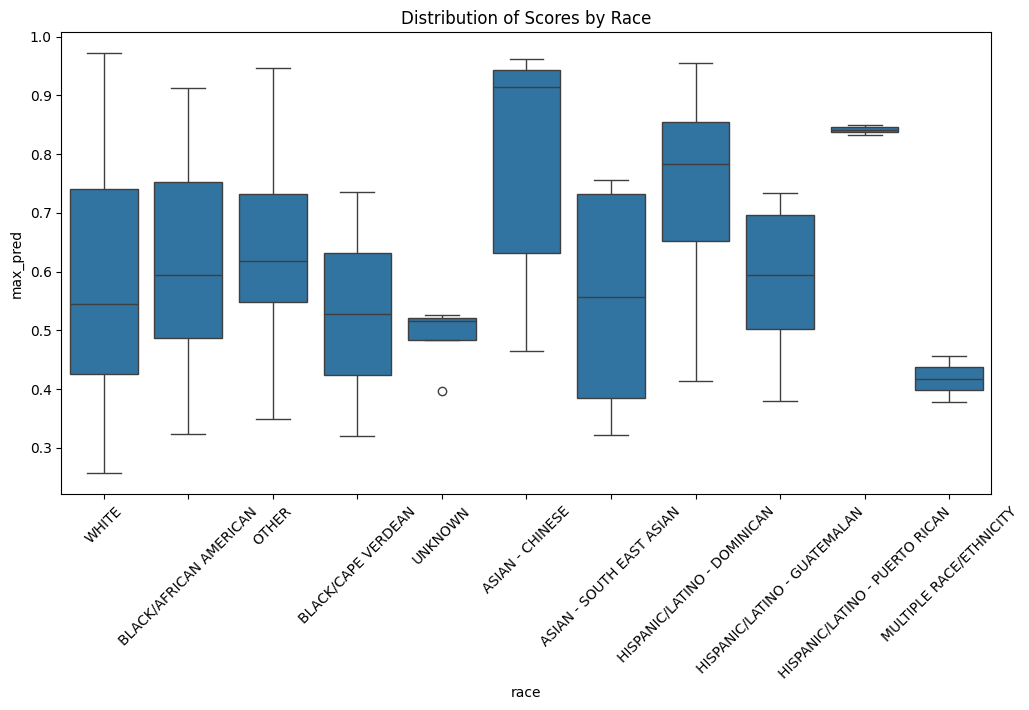

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.boxplot(x='race', y='max_pred', data=df)
plt.title('Distribution of Scores by Race')
plt.xticks(rotation=45)
plt.show()
